<a href="https://colab.research.google.com/github/sbooeshaghi/BMGP_2020/blob/main/analysis/notebooks/barcode_validator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone --quiet https://github.com/sbooeshaghi/BMGP_2020

In [3]:
!pip install --upgrade --quiet setuptools
### 
# Restart runtime after this cell
###

     |████████████████████████████████| 1.2 MB 4.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
numba 0.56.2 requires setuptools<60, but you have setuptools 65.3.0 which is incompatible.


In [4]:
!pip install --quiet git+https://github.com/sbooeshaghi/qcbc.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done


In [5]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

from qcbc.qcbc_volume import qcbc_volume
from qcbc.qcbc_ambiguous import qcbc_ambiguous
from qcbc.qcbc_pdist import qcbc_pdist
from qcbc.qcbc_content import qcbc_content
from qcbc.qcbc_homopolymer import qcbc_homopolymer
from qcbc.utils import make_ec, load_bcs, list_ambiguous

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [6]:
fb_fn = "BMGP_2020/references/10xFB/kite/feature_barcodes.txt"
bcs, bcs_names = load_bcs(fb_fn)

In [7]:
# volume
x  = np.arange(2,len(bcs[0]) + 1)
bc_len = min([len(i) for i in bcs])
print(f"{qcbc_volume(bc_len):,.0f}")

# ambiguity
ambig_bcs = qcbc_ambiguous(*[make_ec(bcs, bcs_names, i) for i in x])
nbc = np.array([len(i) for i in list_ambiguous(ambig_bcs)])

# pdist
pdist = qcbc_pdist(bcs)
pdist_rc = qcbc_pdist(bcs, True)

# content
content = entropy(np.array([list(i["freq"].values()) for i in qcbc_content(bcs, bcs_names)]), axis=1) / np.log2(4)

# homopolymer
hp = np.array([list(i["homopolymers"].values()) for i in qcbc_homopolymer(bcs, bcs_names)])

1,073,741,824


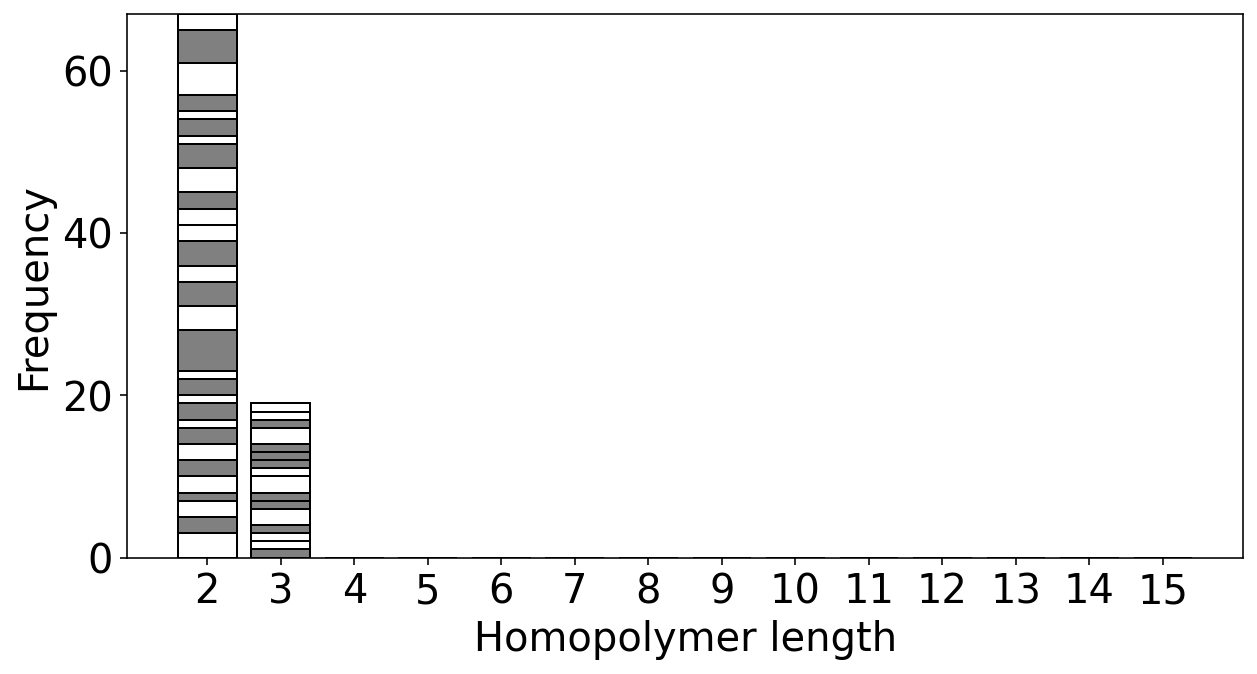

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))

toggle = itertools.cycle(["white", "grey"]).__next__

x = np.arange(hp.shape[1])+2
y = hp[0].copy()
ax.bar(x,y, edgecolor="k", facecolor=toggle())
for r in hp[1:]:
  ax.bar(x,r, bottom=y, edgecolor="k", facecolor=toggle())
  y+=r

ax.set(**{
    "xlabel": "Homopolymer length",
    "ylabel": "Frequency",
    "xticklabels": x,
    "xticks": x
})
fig.show()

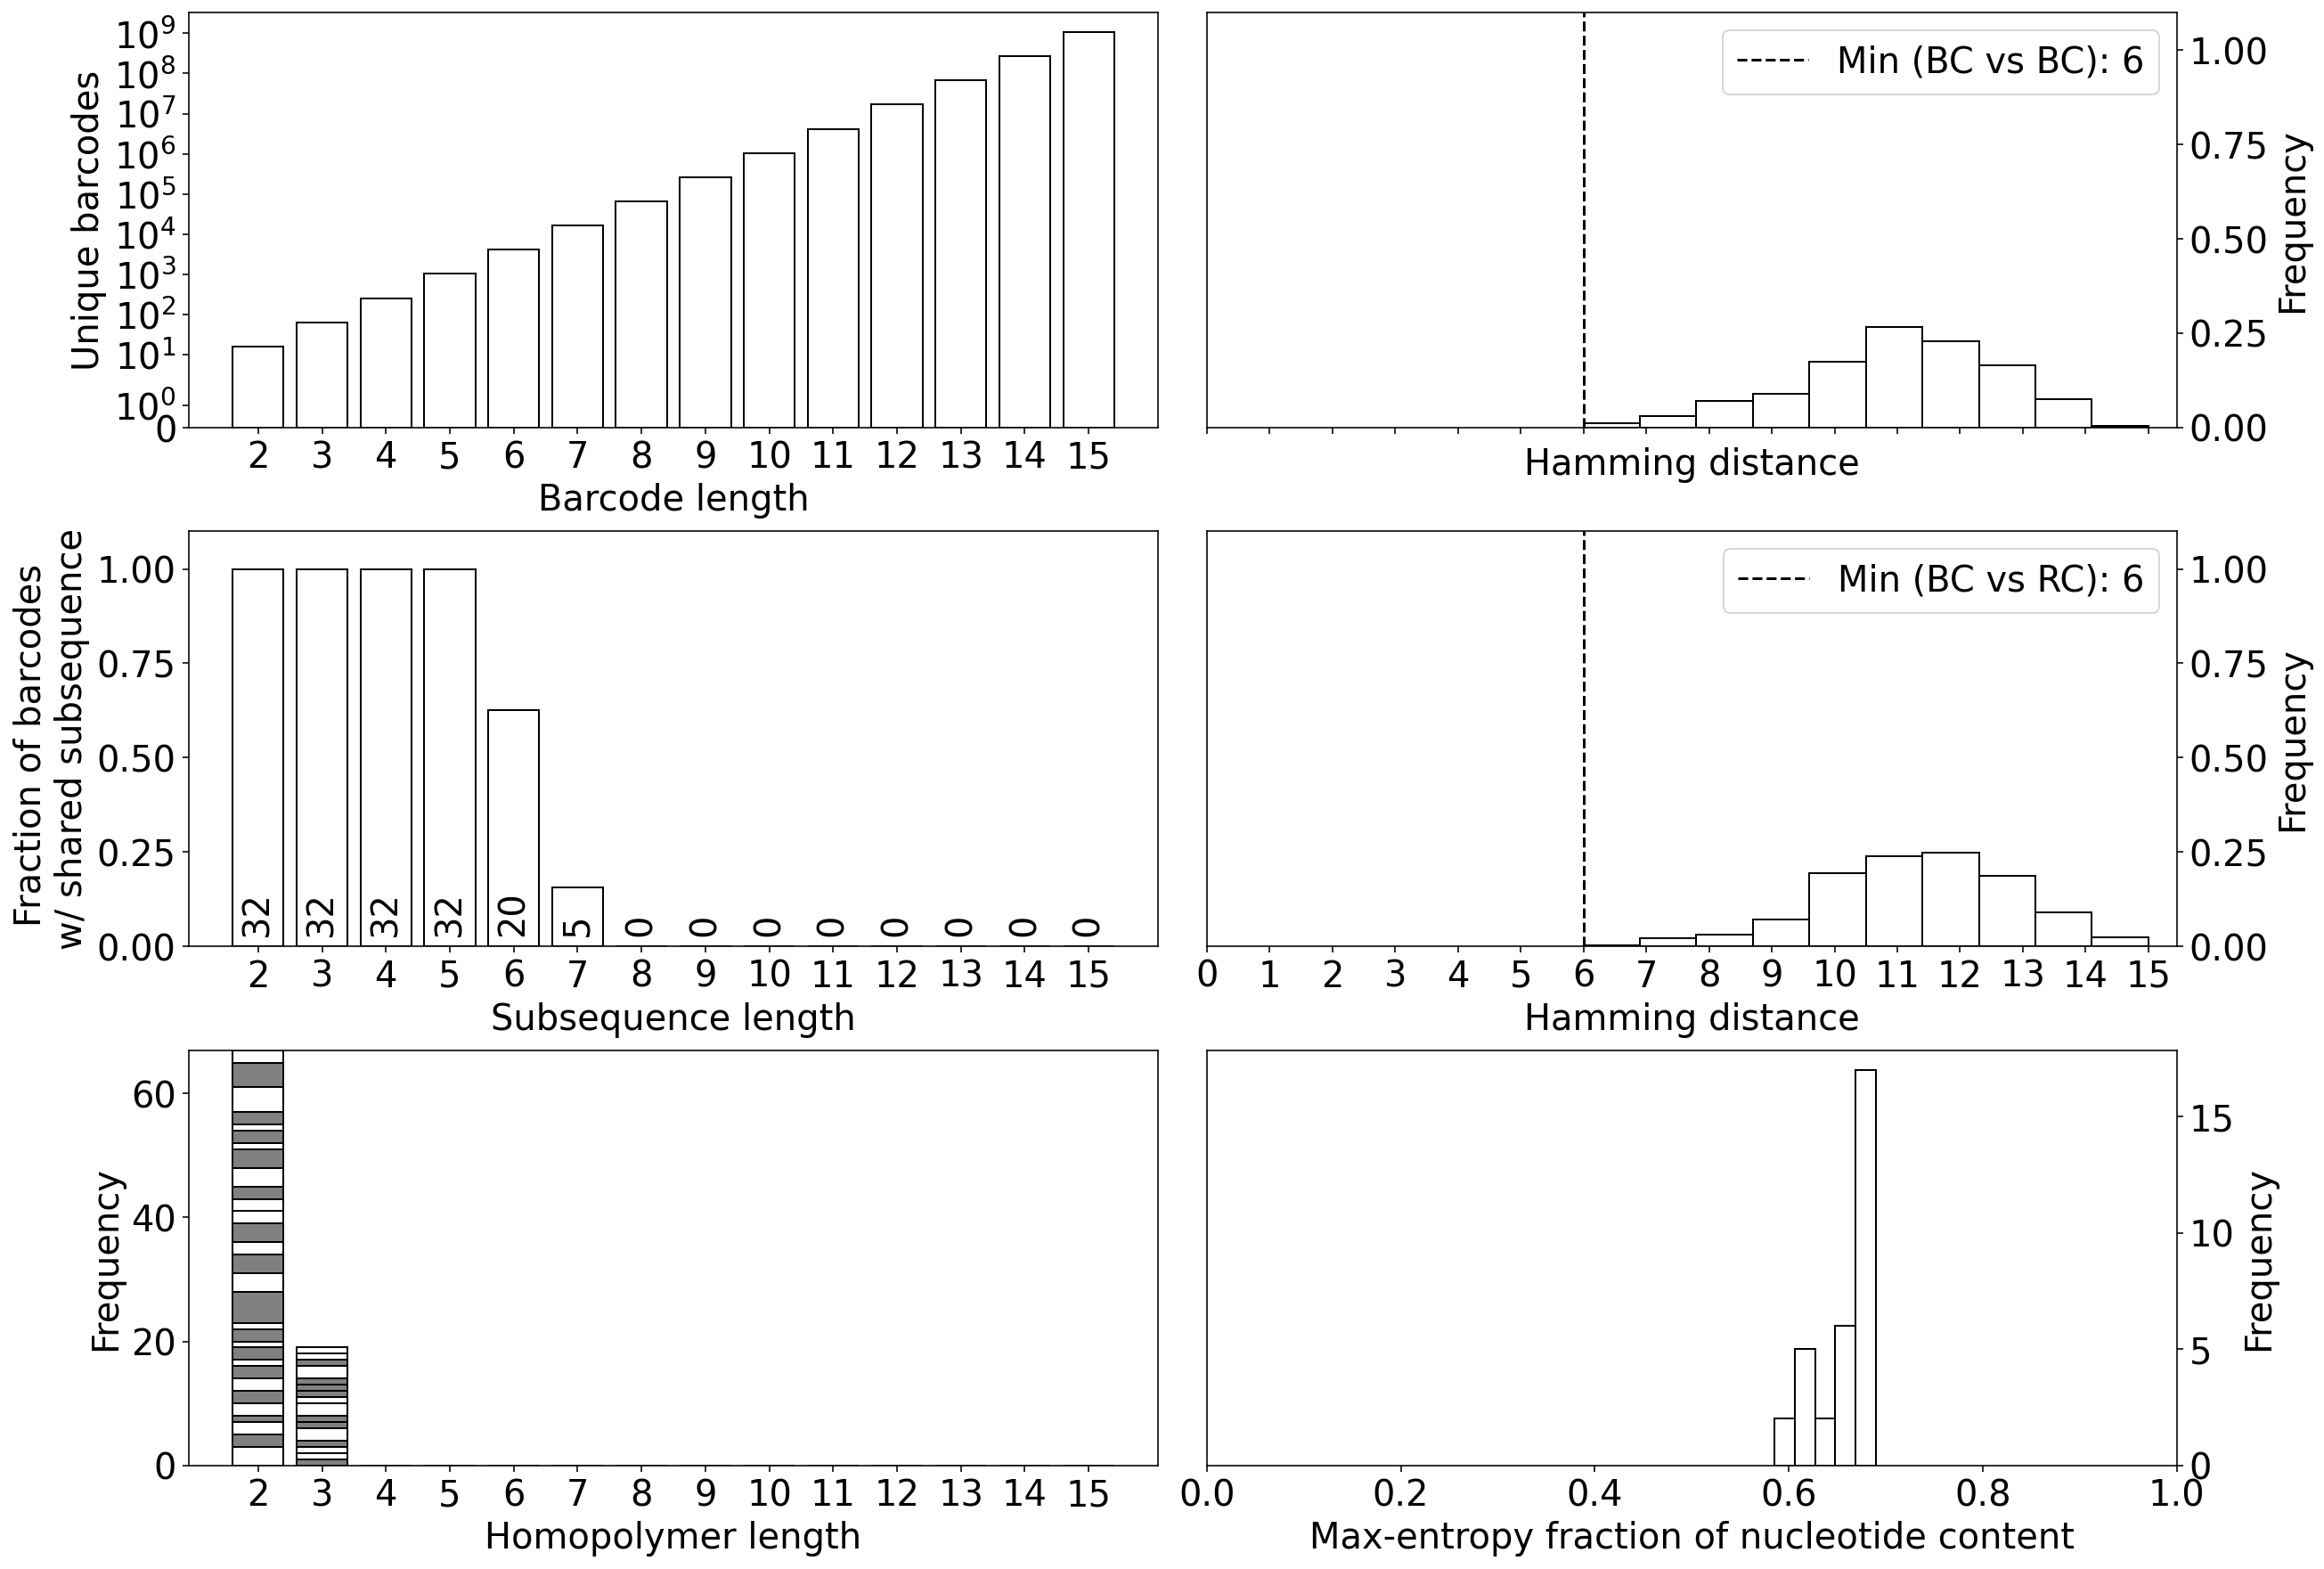

In [12]:
fig, axs = plt.subplots(figsize=(20,15), ncols=2, nrows=3)
fig.subplots_adjust(hspace=0.25, wspace=0.05)

## Barcode diversity
ax = axs[0,0]
x  = np.arange(2,len(bcs[0]) + 1)
y = 4**x

ax.bar(x, y, edgecolor="k", color="white")
ax.set(**{
    "yscale": "symlog",
    "xticks": x,
    "xlabel": "Barcode length",
    "ylabel": "Unique barcodes"
})


#############################################
# Shared subseq
ax = axs[1, 0]
y = nbc / len(bcs)

for idx, (xx, yy) in enumerate(zip(x,y)):
  ax.text(xx, 0.05, f"{nbc[idx]:,.0f}", ha="center", rotation=90)

ax.bar(x, y, edgecolor="k", color="white")
ax.set(**{
    "ylim": (0, 1.1),
    "xticks": x,
    "xlabel": "Subsequence length",
    "ylabel": "Fraction of barcodes \nw/ shared subsequence",
})

#############################################
## Pairwise hamming
ax = axs[0,1]
x = pdist
ax.hist(x, density=True, edgecolor="k", color="white")
mn = min(x)
ax.axvline(mn, label=f"Min (BC vs BC): {mn:,.0f}", color="k", linestyle="--")
ax.set(**{
    "xlabel": "Hamming distance",
    "ylabel": "Frequency",
    "ylim": (0,1.1),
    "xticks": np.arange(0, int(max(x))+1),
    "xticklabels": []
})
ax.legend()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

########################################
ax = axs[1,1]
x = pdist_rc
ax.hist(x, density=True, edgecolor="k", color="white")
mn = min(x)
ax.axvline(mn, label=f"Min (BC vs RC): {mn:,.0f}", color="k", linestyle="--")

ax.set(**{
    "xlabel": "Hamming distance",
    "ylabel": "Frequency",
    "ylim": (0,1.1),
    "xticks": np.arange(0, int(max(x))+1),
    "xticklabels": np.arange(0, int(max(x))+1),
})
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")


ax.legend()

#######################################
# homopolymer
ax = axs[2,0]
toggle = itertools.cycle(["white", "grey"]).__next__

x = np.arange(hp.shape[1])+2
y = hp[0].copy()
ax.bar(x,y, edgecolor="k", facecolor=toggle())
for r in hp[1:]:
  ax.bar(x,r, bottom=y, edgecolor="k", facecolor=toggle())
  y+=r

ax.set(**{
    "xlabel": "Homopolymer length",
    "ylabel": "Frequency",
    "xticklabels": x,
    "xticks": x
})

# Content
ax = axs[2,1]
x = content
ax.hist(x, edgecolor="k", facecolor="white", bins=5)
ax.set(**{
    "xlim": (0, 1),
    "xlabel": "Max-entropy fraction of nucleotide content",
    "ylabel": "Frequency"
})

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

fig.show()